# Machine Learning to Detect Fraudulent Bank Payments

## Objectives
The objective of this project is to build a prediction model that detects fraudulent transactions. 
This is useful for businesses as being able to detect fraudulent payments can save business billions of dollars.
ML offers the potential to reduce the risk of loss from fraud. 

## About Banksim dataset

This is a synthetically generated dataset consisting of payments from various customers made at different time periods and with different amounts. For more information on the dataset you can check the [Kaggle page](https://www.kaggle.com/ealaxi/banksim1) for this dataset which also has the link to the original paper. 

## Process steps
1. Exploratory Data Analysis
2. Data Preprocessing
3. Handling the imbalanced dataset
4. Spliting the dataset for training the models
5. Training the models using K-Neighbor, Random Forest and XGBoost classifiers
6. Evaluating the performance of the models

In [181]:
## Importing necessary dependencies 

# For loading the data & processing 
import pandas as pd
pd.options.display.max_rows = 100
import numpy as np
from imblearn.over_sampling import SMOTE

# For Visualization
import seaborn as sns
import matplotlib.pyplot as plt # set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Explaratory Data Analysis
Performing EDA to gain some insight from the data.

The dataset contains 9 feature columns and a target column. 
The target variable shows if the transaction is fraudulent(1) or not fraudulent (0)
The feature columms are :
* **Step**: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
* **Customer**: This feature represents the customer id
* **zipCodeOrigin**: The zip code of origin/source.
* **Merchant**: The merchant's id
* **zipMerchant**: The merchant's zip code
* **Age**: Categorized age 
    * 0: <= 18, 
    * 1: 19-25, 
    * 2: 26-35, 
    * 3: 36-45,
    * 4: 46:55,
    * 5: 56:65,
    * 6: > 65
    * U: Unknown
* **Gender**: Gender for customer
     * E : Enterprise,
     * F: Female,
     * M: Male,
     * U: Unknown
* **Category**: Category of the purchase. 
* **Amount**: Amount of the purchase

In [110]:
# load and read the dataset
data = pd.read_csv("bs140513_032310.csv")
data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


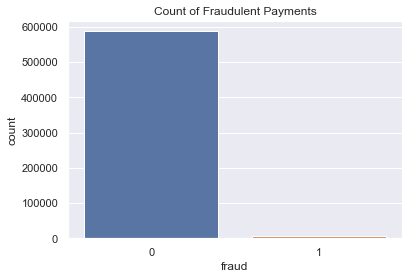

Number of normal transactions:  587443
Number of fradulent transactions:  7200


In [164]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal transactions: ",df_non_fraud.fraud.count())
print("Number of fradulent transactions: ",df_fraud.fraud.count())

# Analysing the feature variables 
Grouping the average transaction amount and fraud label by category shows that travel, health, toys and hotels have the most fraud. 

In [167]:
fraud_totals =  data.groupby(['category', 'fraud'])['amount'].sum().reset_index().rename(columns={'category':'Category', 'fraud': 'Fraud', 'amount' : 'Amount'}).sort_values('Amount')

fraud_totals

,Category,Fraud,Amount
14,'es_leisure',0,1830.76
1,'es_barsandrestaurants',1,19691.12
4,'es_fashion',1,28652.95
2,'es_contents',0,39424.60
13,'es_hyper',1,47391.52
16,'es_otherservices',0,51768.88
21,'es_tech',1,65613.31
17,'es_otherservices',1,72155.07
23,'es_travel',0,100353.83
10,'es_hotelservices',0,127432.06


## Showing the average transaction amount for each category

In [138]:
print("Group transaction category by fraud and average amount per transaction")
#cat = data.groupby(['category']).agg({'amount': 'sum'}).sort_values(by='amount')
cat = data.groupby(['category', 'fraud'])['amount'].mean().reset_index().rename(columns={'category':'Category', 'fraud': 'Fraud', 'amount' : 'Amount'}).sort_values('Amount')
cat

Group transaction category by fraud and average amount per transaction


,Category,Fraud,Amount
22,'es_transportation',0,26.958187
5,'es_food',0,37.070405
12,'es_hyper',0,40.037145
0,'es_barsandrestaurants',0,41.145997
2,'es_contents',0,44.547571
25,'es_wellnessandbeauty',0,57.320219
3,'es_fashion',0,62.347674
14,'es_leisure',0,73.230400
16,'es_otherservices',0,75.685497
18,'es_sportsandtoys',0,88.502738


In [68]:
print("Sum the feature values per category")
# cat = df_fraud.groupby([ 'age']).agg({'amount': 'sum'})
cat = df_fraud.groupby(['age', 'gender'])['amount'].sum()
cat_percentage = cat.groupby(level=0).apply(lambda x:   x / float(x.sum())*100)
cat_percentage

Sum the feature values per category


age  gender
'0'  'F'        73.214599
     'M'        26.785401
'1'  'F'        73.819492
     'M'        26.180508
'2'  'F'        67.390148
     'M'        32.609852
'3'  'F'        62.273014
     'M'        37.726986
'4'  'F'        58.799636
     'M'        41.200364
'5'  'F'        75.465624
     'M'        24.534376
'6'  'F'        60.146386
     'M'        39.853614
'U'  'E'       100.000000
Name: amount, dtype: float64

## Calculating the percentage of amount lost to fraud

In [178]:
fraud_amount = data.groupby(['fraud']).agg({'amount': 'sum'})
print(fraud_amount)

pct1 = df_fraud.amount.sum()/(data.amount.sum())*100
pct2 = df_fraud.amount.sum()/ np.add(df_non_fraud.amount.sum(),df_fraud.amount.sum()) * 100

print('Percentage of transaction amount that are fraud: ',pct1)


            amount
fraud             
0      18708432.56
1       3822671.17
Percentage of transaction amount that are fraud:  16.96619577899391
16.966195778993917


20.4328778359185

### 65% of fraudulent transactions were done on Female accounts, while 34% were on Male and less than 0.1% on Enterprise accounts.

In [92]:
df = data.groupby(['fraud', 'gender']).agg({'amount': 'sum'})
print(df)
# # Change: groupby state_office and divide by sum
df_pcts = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df_pcts

                   amount
fraud gender             
0     'E'        39833.13
      'F'     10223625.68
      'M'      8428746.65
      'U'        16227.10
1     'E'         3314.21
      'F'      2503555.82
      'M'      1315801.14


amount
fraud gender           
0     'E'      0.212915
      'F'     54.647153
      'M'     45.053195
      'U'      0.086737
1     'E'      0.086699
      'F'     65.492314
      'M'     34.420987

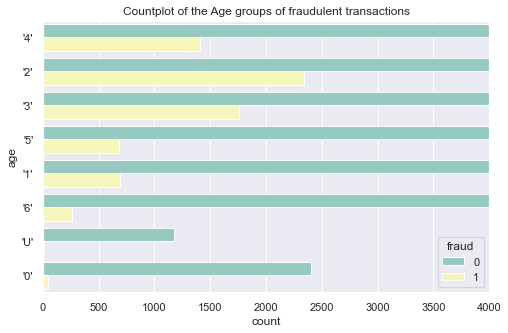

In [83]:
# Plot the distribution of the age feature for transactions labeled as fraud  
plt.figure(figsize=(8,5))
sns.countplot(y=data.age,data=data,hue='fraud', palette='Set3')
plt.title("Countplot of the Age groups of fraudulent transactions")
plt.xlim(0,4000)
plt.show()

Again we can see in the histogram below the fradulent transactions are less in count but more in amount.

(0.0, 4000.0)

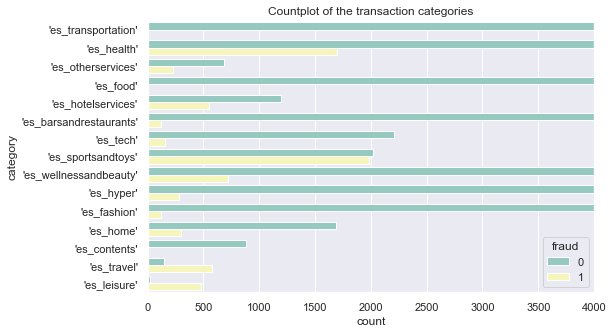

In [105]:
plt.figure(figsize=(8,5))
sns.countplot(y =data.category, hue='fraud', data = data, palette='Set3')
plt.title("Countplot of the transaction categories")
plt.xlim(0,4000)

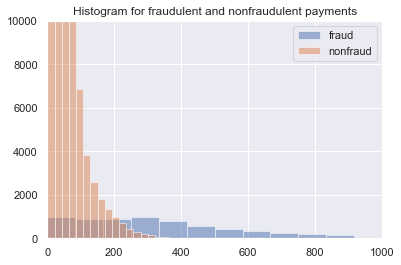

In [106]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

## Data Preprocessing

Dropping the zipCodeOri and zipMerchant as have only one unique value.

In [139]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_prep = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


Checking the data after dropping zipCodeOri & zipMerchant.

In [141]:
data_prep

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','M1823072687','es_transportation',20.53,0
594639,179,'C650108285','4','F','M1823072687','es_transportation',50.73,0
594640,179,'C123623130','2','F','M349281107','es_fashion',22.44,0
594641,179,'C1499363341','5','M','M1823072687','es_transportation',14.46,0


## Transform categorical features into numerical values. 
Although it is better encode categorical values into dummies as they have no relation in size(male is not greater in value than female) but this dataset has 500,000 customers and merchants) doing this operation is not effecient and it will take forever to train. Therefore, pandas cat.codes method to code the categorical variables to numeric value will be better.

In [142]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_prep.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_prep[col] = data_prep[col].astype('category')
# categorical values ==> numeric values
data_prep[col_categorical] = data_prep[col_categorical].apply(lambda x: x.cat.codes)
data_prep.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [148]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  
 1   customer  594643 non-null  int16  
 2   age       594643 non-null  int8   
 3   gender    594643 non-null  int8   
 4   merchant  594643 non-null  int8   
 5   category  594643 non-null  int8   
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  int64  
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 17.0 MB


Let's define our independent variable (X) and dependant/target variable y

In [147]:
X = data_prep.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [149]:
y[y==1].count()

7200

## Oversampling with SMOTE

Using SMOTE(Synthetic Minority Oversampling Technique) for balancing the dataset. Resulted counts show that now we have exact number of class instances (1 and 0).

The dataset is imbalanced. To balance the dataset one can perform oversample or undersample techniques. Oversampling is increasing the number of the minority class by generating instances from the minority class . Undersampling is reducing the number of instances in the majority class by selecting random points from it to where it is equal with the minority class. Both operations have pros and cons: Oversample will create copies or similar data points which sometimes would not be helpful for the case of fraud detection because fraudulent transactions may vary. Undersampling means that we lose data points thus information. We will perform an oversampling technique called SMOTE (Synthetic Minority Over-sampling Technique). SMOTE will create new data points from minority class using the neighbour instances so generated samples are not exact copies but they are similar to instances we have.

In [153]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
y_res['fraud'].value_counts()


0    587443
1    587443
Name: fraud, dtype: int64

## Split the dataset into train and test

In [156]:
# Split the datasets into train and test 
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

## Defining a function for plotting the ROC_AUC curve. It is a good visual way to see the classification performance.

In [158]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Setting a base performance score for the model. This means the model should be better than a random guess or base score.

In [179]:
# The base score should be better than predicting always non-fraduelent
base_score = df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100
print("Base accuracy score we must beat is: ", base_score)

Base accuracy score we must beat is:  98.7891894800746


## **K-Neighbours Classifier**

/Users/oma/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


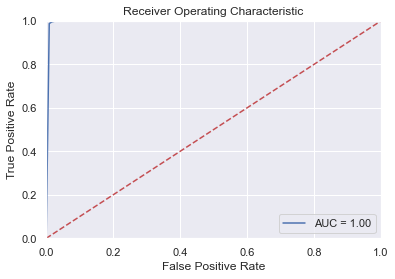

In [159]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

## **Random Forest Classifier**

/var/folders/cy/04tph_755lq1w6j9m06722jr0000gn/T/ipykernel_71410/2368093465.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.1s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


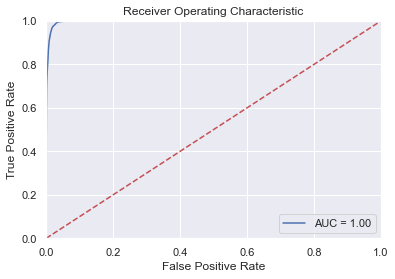

In [160]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

## XGBoost Classifier

[22:17:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174047   2186]
 [   706 175527]]


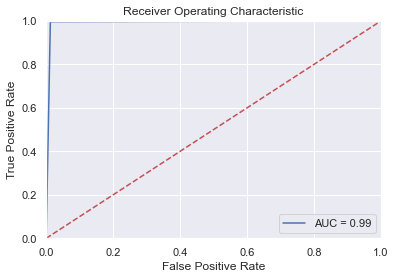

In [162]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

## Conclusion & Model Performance Evaluation
The models developed performed well with the following accuracy scores:

In [184]:
y_pred_K = knn.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = XGBoost_CLF.predict(X_test)
print('Base Score: ', base_score)
print('KNeighbor Model: ',accuracy_score(y_test, y_pred_K) * 100)
print('Random Forest Model: ', accuracy_score(y_test, y_pred_rf) * 100)
print('XGBoost Model: ', accuracy_score(y_test, y_pred_xgb) * 100)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


Base Score:  98.7891894800746
KNeighbor Model:  98.69604444116595
Random Forest Model:  97.95554748543121
XGBoost Model:  99.17949532720887
